In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, cross_validation
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
### Reading data

data = pd.read_csv('../data/data.csv')
data.set_index('shot_id', inplace=True)
# The following should be explicitly made categorical as they are encoded using integers
data["action_type"] = data["action_type"].astype('object')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

In [3]:
# data cleaning
##
unknown_mask = data['shot_made_flag'].isnull()
data_cl = data.copy()
target = data_cl['shot_made_flag'].copy()
data_cl.drop('team_id', inplace=True, axis=1)  # only 1 category
data_cl.drop('lat', inplace=True, axis=1)  # correlated with loc_x
data_cl.drop('lon', inplace=True, axis=1)  # correlated with loc_y
data_cl.drop('game_id', inplace=True, axis=1)  # should not be dependent on game id
data_cl.drop('game_event_id', inplace=True, axis=1)  # independent, unique for every shots in a game
data_cl.drop('team_name', inplace=True, axis=1)  # always LA Lakers
data_cl.drop('shot_made_flag', inplace=True, axis=1)  # target variables
#data_cl.drop('season', axis=1, inplace=True) # obtained a very good accuracy when season is dropped
#data_cl.drop('shot_zone_range', axis=1, inplace=True) # obtained accuracy improvement after dropping season
#data_cl.drop('combined_shot_type', axis=1, inplace=True) # obtained accuracy improvement after dropping game_month 
#data_cl.drop('shot_type', axis=1, inplace=True) # obtained accuracy improvement after dropping combined_shot_type

In [4]:
# Game date -- extract year and month
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])
data_cl['game_year'] = data_cl['game_date'].dt.year
data_cl.drop('game_date', axis=1, inplace=True)

In [5]:
#Extract time related features
data_cl['time_remaining'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_3_sec'] = data_cl['time_remaining'] < 3
data_cl['last_5_sec'] = data_cl['time_remaining'] < 5
data_cl['last_10_sec'] = data_cl['time_remaining'] < 10

# drop redundant features
data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('time_remaining', axis=1, inplace=True)

In [6]:
from sklearn import mixture
gaussianMixtureModel1 = mixture.GMM(n_components= 16, covariance_type='full', params='wmc', init_params='wmc',
                                    random_state=1, n_init=3,  verbose=0)
gaussianMixtureModel1.fit(data_cl.ix[:,['loc_x','loc_y']])
data_cl['shotLocationCluster'] = gaussianMixtureModel1.predict(data_cl.ix[:,['loc_x','loc_y']])

data_cl.drop('loc_x', axis=1, inplace=True)
data_cl.drop('loc_y', axis=1, inplace=True)

In [7]:
## Matchup -- (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

In [8]:
data_cl['first_period'] = data_cl['period'] == 1
data_cl['second_period'] = data_cl['period'] == 2
data_cl['third_period'] = data_cl['period'] == 3
data_cl['fourth_period'] = data_cl['period'] == 4
data_cl['final_period'] = data_cl['period'] > 4
data_cl.drop('period', axis=1, inplace=True)

In [9]:
# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

In [10]:
# Replace  least common action types with value 'rare'
rare_opponent = data_cl['opponent'].value_counts().sort_values().index.values[:30]
data_cl.loc[data_cl['opponent'].isin(rare_opponent), 'opponent'] = 'rare'

In [11]:
data_cl.columns

Index(['action_type', 'combined_shot_type', 'playoffs', 'season',
       'shot_distance', 'shot_type', 'shot_zone_area', 'shot_zone_basic',
       'shot_zone_range', 'opponent', 'game_year', 'last_3_sec', 'last_5_sec',
       'last_10_sec', 'shotLocationCluster', 'home_play', 'first_period',
       'second_period', 'third_period', 'fourth_period', 'final_period'],
      dtype='object')

In [12]:
data_cl.describe()

,shot_distance,game_year,shotLocationCluster,home_play
count,30697.000000,30697.000000,30697.000000,30697.000000
mean,13.437437,2006.098446,6.776688,0.487214
std,9.374189,4.835462,4.442815,0.499845
min,0.000000,1996.000000,0.000000,0.000000
25%,5.000000,2002.000000,3.000000,0.000000
50%,15.000000,2006.000000,6.000000,0.000000
75%,21.000000,2010.000000,10.000000,1.000000
max,79.000000,2016.000000,15.000000,1.000000


In [13]:
# One-hot encoding of categorical variables
categorial_cols = ['action_type', 'combined_shot_type', 'season','playoffs', 'shot_zone_range', 'shot_type','shot_zone_area','shot_zone_basic', 'opponent', 'shotLocationCluster']

for cc in categorial_cols:
    dummies = pd.get_dummies(data_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data_cl.drop(cc, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)

In [14]:
# Train/validation split
# Separate dataset for validation
data_submit = data_cl[unknown_mask]
# Separate dataset for training
X = data_cl[~unknown_mask]
Y = target[~unknown_mask]

In [15]:
print('Clean dataset shape: {}'.format(data_cl.shape))

Clean dataset shape: (30697, 117)


In [42]:
regr = LogisticRegression(C=0.7, penalty='l1')
predicted = cross_validation.cross_val_predict(regr, X, Y, cv=10)
print(metrics.accuracy_score(Y, predicted))
print(metrics.classification_report(Y, predicted))

0.665408413433
             precision    recall  f1-score   support

        0.0       0.65      0.84      0.74     14232
        1.0       0.70      0.44      0.54     11465

avg / total       0.67      0.67      0.65     25697



In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
logit_model = sm.Logit(y_train, X_train.astype(float)).fit()
logit_model.pvalues.to_csv("../data/pvalues.csv")

         Current function value: 0.602127
         Iterations: 35


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [87]:
logit_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                             Results: Logit
=========================================================================================================
Model:                            Logit                         No. Iterations:                35.0000   
Dependent Variable:               shot_made_flag                Pseudo R-squared:              0.124     
Date:                             2018-03-16 20:03              AIC:                           24965.8360
No. Observations:                 20557                         BIC:                           25798.5864
Df Model:                         104                           Log-Likelihood:                -12378.   
Df Residuals:                     20452                         LL-Null:                       -14136.   
Converged:                        0.0000                        Scale:                         1.0000    
---------------------------------------------------------------------------------------------------------
                                            Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
---------------------------------------------------------------------------------------------------------
shot_distance                               0.0158       0.0118  1.3449 0.1787       -0.0072       0.0389
game_year                                  -0.0226       0.0361 -0.6262 0.5312       -0.0933       0.0481
last_3_sec                                 -0.7281       0.2289 -3.1807 0.0015       -1.1767      -0.2794
last_5_sec                                  0.0931       0.2631  0.3538 0.7235       -0.4225       0.6086
last_10_sec                                -0.2509       0.1731 -1.4499 0.1471       -0.5902       0.0883
home_play                                   0.0527       0.0310  1.6985 0.0894       -0.0081       0.1135
first_period                                3.8562          nan     nan    nan           nan          nan
second_period                               3.8040          nan     nan    nan           nan          nan
third_period                                3.7870 2419311.8537  0.0000 1.0000 -4741760.3137 4741767.8877
fourth_period                               3.6525  755419.2229  0.0000 1.0000 -1480590.8177 1480598.1227
final_period                                3.6868          nan     nan    nan           nan          nan
action_type#Alley Oop Dunk Shot             0.9074  525880.9435  0.0000 1.0000 -1030706.8020 1030708.6168
action_type#Alley Oop Layup shot           -0.4722  577247.5813 -0.0000 1.0000 -1131384.9416 1131383.9972
action_type#Driving Dunk Shot               1.6762  563865.9401  0.0000 1.0000 -1105155.2586 1105158.6110
action_type#Driving Finger Roll Layup Shot  0.9911 1052724.6705  0.0000 1.0000 -2063301.4487 2063303.4310
action_type#Driving Finger Roll Shot        0.4897  829464.8046  0.0000 1.0000 -1625720.6538 1625721.6333
action_type#Driving Jump shot              -1.9307          nan     nan    nan           nan          nan
action_type#Driving Layup Shot             -0.1298 1121534.7403 -0.0000 1.0000 -2198167.8282 2198167.5686
action_type#Driving Reverse Layup Shot     -0.1800  458729.5233 -0.0000 1.0000  -899093.5243  899093.1643
action_type#Driving Slam Dunk Shot          1.3209  703251.2408  0.0000 1.0000 -1378345.7832 1378348.4250
action_type#Dunk Shot                      -0.7786  232676.8002 -0.0000 1.0000  -456038.9271  456037.3699
action_type#Fadeaway Bank shot              0.5543 1018763.1375  0.0000 1.0000 -1996738.5039 1996739.6126
action_type#Fadeaway Jump Shot             -1.4009          nan     nan    nan           nan          nan
action_type#Finger Roll Layup Shot          0.3021          nan     nan    nan           nan          nan
action_type#Finger Roll Shot               -1.6851 1027879.4300 -0.0000 1.0000 -2014608.3483 2014604.9781
action_type#Floating Jump shot             -0.6395  667704.6588 -0.0000 1.0

In [62]:
predicted = logit_model.predict(X_test.astype(float))
predicted = [1 if x > 0.5 else 0 for x in predicted]
print(metrics.accuracy_score(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

0.687548638132
             precision    recall  f1-score   support

        0.0       0.67      0.87      0.76      2875
        1.0       0.74      0.45      0.56      2265

avg / total       0.70      0.69      0.67      5140



In [73]:
data_submit = data_cl[unknown_mask]
preds = logit_model.predict(data_submit.astype(float))

In [83]:
preds.to_frame().to_csv("../data/sub.csv",index=True)

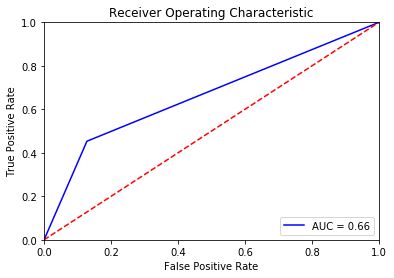

In [64]:
fpr, tpr, threshold = metrics.roc_curve(y_test, predicted)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()